In [70]:
# import argparse
import pandas as pd
import json
import collections
from typing import Union, List
import os
import requests
import numpy as np
import dsp
import random

def extract_entity(x: list):
    res = []
    for entity in x:
        if entity["entityType"] == "entity":
            res.append(entity["label"] if entity["label"] else entity["mention"])
    return res




def cal_popularity(x: list) -> list:
    endpoint = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "prop": "pageviews",
        "titles": None,
        "format": "json",
        "pvipmetric": "pageviews"

    }
    pageviews = []
    for entity in x:
        if entity:
            params["titles"] = entity.replace(' ', '_')
            try:
                response = requests.get(endpoint, params=params)
                response.raise_for_status()
                response = response.json()
            except Exception as ex:
                raise ex
            try:
                pages = response["query"]["pages"]
                views = []
                for page in pages.keys():
                    try:
                        content = pages[page]["pageviews"]
                        df = pd.DataFrame.from_dict({"date": content.keys(), "views": content.values()})
                        df = df.dropna()
                        views.append(df.views.sum())
                    except:
                        continue
                if views:
                    pageviews.append(int(sum(views)))
                else:
                    pageviews.append(None)
            except:
                pageviews.append(None)
        else:
            pageviews.append(None)
#     print(pageviews)
    return pageviews


# load mintaka functions
path = "dataset/test"
files = os.listdir(path)
with open("dataset/relation_query_templates.json", "r") as f:
    templates = json.loads(f.read())

for f in files:
    # find entity location
    file_type = f.split('.')[0]
    lst = templates[file_type].split("[X]")
    lst = [len(i) for i in lst]
    # extract entity
    df = pd.read_json('/'.join([path, f]))
    if "q_pop" in df.columns:
        print(f"file {f} already done!")
    else:
        print("Getting pop data...")
        df["question_entity"] = df["question"].apply(lambda x: [x[lst[0]:-lst[1]]])
        df["q_pop"] = df["question_entity"].apply(lambda x: cal_popularity(x))
        df.to_json('/'.join([path, f]), orient="records", indent=4)
        print(f"file {f} updated!")


file P69.test.json already done!
file P170.test.json already done!
file P26.test.json already done!
file P407.test.json already done!
file P413.test.json already done!
file P20.test.json already done!
file P176.test.json already done!
file P495.test.json already done!
file P276.test.json already done!
file P106.test.json already done!
file P112.test.json already done!
file P50.test.json already done!
file P127.test.json already done!
file P19.test.json already done!
file P264.test.json already done!
file P800.test.json already done!
file P136.test.json already done!
file P740.test.json already done!
file P17.test.json already done!
file P36.test.json already done!
file P131.test.json already done!
file P159.test.json already done!
file P40.test.json already done!
file P175.test.json already done!


In [71]:
def entity_question_data(n_sample: int = 30, thres: int = 1):
    final = []
    
    for f in files:
        df = pd.read_json('/'.join([path, f]))
        df["pop_bin"] = np.log10(df["q_pop"].apply(lambda x: x[0]+1 if x[0] else None))
        df = df.dropna()
        df["pop_bin"] = df["pop_bin"].apply(int)
        # filter low pop data
        data = df[df["pop_bin"]<=thres]
        true_n = n_sample if len(data) >= n_sample else len(data)
        data = data.sample(n=true_n, random_state=100)
        section = list(pd.concat([data['question'], data['answers']], axis=1).apply(tuple, axis=1))
        section = [dsp.Example(question=question, answer=answer) for question, answer in section]
        final += section
        
    return final

data = entity_question_data()
random.Random(100).shuffle(data)
data[:3]

[{'question': 'Where is Mouilly located?', 'answer': ['Meuse']},
 {'question': 'Which country is Plum Lake located in?',
  'answer': ['United States of America']},
 {'question': 'What kind of work does Patrick Parisot do?',
  'answer': ['diplomat']}]

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def clean(x: list):
    if (None in x) and (len(set(x)) == 1):
#         print("IN!!")
        return None
    clean_list = [i for i in x if i]
    nums = np.array(clean_list)
    return np.average(nums)
    
cleaned = question_popularity.apply(lambda x: clean(x))
print(sum(cleaned.isnull()))
# print(len(cleaned))
plt.figure(figsize=(8, 10))
plt.hist(np.log10(cleaned), bins=10)
plt.xlabel("num of entity search in past 60 days (log 10 based)")
plt.ylabel("num of questions")
plt.title("Popularity distribution in Mintaka")
# test.apply(lambda x: mock(x))

NameError: name 'question_popularity' is not defined

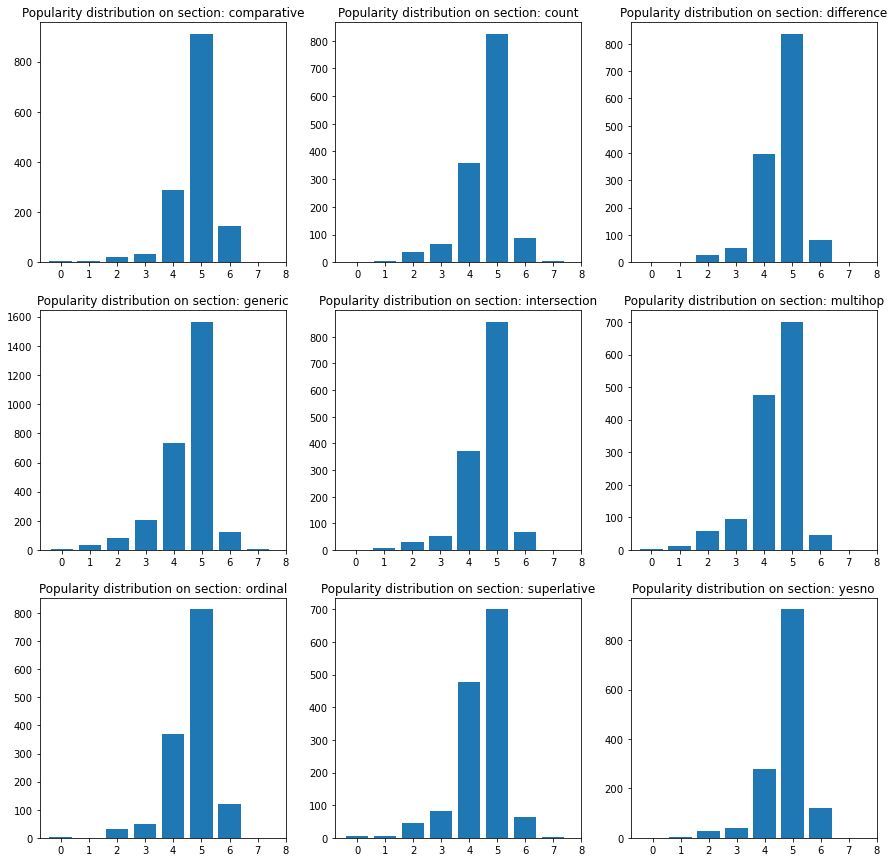

In [214]:
train = load_mintaka("data/mintaka_train.json")
train["log_pop"] = np.log10(cleaned)
train.answer = train.answer.apply(lambda x: [x] if type(x) is str else [str(i) for i in x])
train = train.dropna()
train.log_pop = train.log_pop.apply(int)
sections = train.groupby('complexityType').log_pop.apply(list)
indices = list(sections.index)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i in range(len(sections)):
    x, y = i//3, i%3
#     axs[x, y].set_xlim(0, 8)
    arr = np.array(sections[i])
    labels, counts = np.unique(arr, return_counts=True)
    axs[x, y].bar(labels, counts, align='center')
    axs[x, y].set_xticks(np.arange(9))
    axs[x, y].set_title(f'Popularity distribution on section: {indices[i]}')
    
#     axs[x, y].hist([str(record) for record in sorted(sections[i])], rwidth=0.7)
    
    
# null_values = train[train.log_pop.isnull()].index
# train.iloc[null_values].questionEntity.values[:10]
# train.head(20)

In [33]:
%load_ext autoreload
%autoreload 2
from create_sample import make_example
from collections import Counter
kwargs = {
    "section": "count",
    "pop_thres": 4
}
train, test = make_example("data/mintaka_train.json", **kwargs)
pops = [ex["pop"] for ex in train]
Counter(sorted(pops))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Counter({0: 15, 1: 3, 2: 33, 3: 49, 4: 29, 5: 65, 6: 6})

In [42]:
class Test:
    def __init__(self, **kwargs):
        self.kwargs = {
            "item a": 100,
            **kwargs
        }
    def print_args(self):
        print(self.kwargs)
        

args = {
    "item b": "hello",
    "item a": 200
}
test = Test(**args)
test.print_args()

{'item a': 200, 'item b': 'hello'}
